In [2]:
import pandas as pd
import psycopg2 as psys
import os
import sys
import plotly.express as pt
import pytz as tz
from warnings import filterwarnings
from datetime import datetime
from meteostat import Hourly
from dotenv import load_dotenv

start = datetime(2023,7,1,00,00,00,00)
end = datetime(2023,8,31,23,59,59,59)

#10675 is Bamberg
data = Hourly(10675,start,end)
weather_data = data.fetch().reset_index()
weather_data = weather_data[['time', 'temp', 'prcp', 'coco']]

print(weather_data.columns)
filterwarnings("ignore", category=UserWarning, message='.*pandas only supports SQLAlchemy connectable.*')




load_dotenv() # take environment variables from .env.
%matplotlib inline

conn = None
def connect():
    try:
        print('Connecting…')
        conn = psys.connect(
            host=os.environ['DB_HOST'],
            database=os.environ['DB_NAME'],
            user=os.environ['DB_USERNAME'],
            password=os.environ['DB_PASSWORD'])
    except (Exception, psys.DatabaseError) as error:
       print(error)
       sys.exit(1)
    print('All good, Connection successful!')
    return conn

conn = connect()
cur = conn.cursor()
query_one = f"""SELECT to_timestamp(floor((extract('epoch' from epocutc)/600))*600)
AT TIME ZONE 'UTC' as time, COUNT(DISTINCT mac_address) as people_count
FROM testschemadb.flowtrack_raw
WHERE zone = 'bz2453'
AND epocutc >= '2023-07-01 00:00:00' AND epocutc <= '2023-08-31 23:59:59'
GROUP BY time;
"""
#600 is 10 minutes in seconds. 
#The idea is to convert timestamp to epoch, divide by interval desired in minutes then round to get the desired interval

crowd_data = pd.read_sql_query(query_one,con=conn)

# Timezone Conversion UTC-->CET
# cet_timezone = tz.timezone('CET')
# crowd_data['time'] = crowd_data['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone)
# weather_data['time'] = weather_data['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone)

print(crowd_data.columns)

# Convert 'time' to datetime and set it as the index
weather_data['time'] = pd.to_datetime(weather_data['time'])
weather_data.set_index('time', inplace=True)

# Resample the hourly data into 10-minute intervals and use the 'ffill' method to fill missing values
data_resampled = weather_data.resample('10T').first().ffill()


# Create a time range with 10-minute intervals for the entire month of August
time_range = pd.date_range(start, end, freq='10T')

# Create a DataFrame with the time range and merge it with the resampled data
result = pd.DataFrame({'time': time_range})
merged_data = pd.merge(data_resampled, crowd_data, on='time', how='outer').bfill()
merged_data = merged_data.ffill()
# Display the result
print(merged_data)
merged_data.to_csv('merged_data.csv')




fig = pt.line(data_frame=merged_data,x='time',y='people_count',width=2400,height=900)
fig.update_yaxes(rangemode='tozero',showspikes=True)
fig.update_xaxes(tickangle=45)
fig.update_layout(
    yaxis=dict(tickmode='linear',dtick=50),
    xaxis=dict(tickmode='linear',tick0='2023-07-01'),
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)
fig.show()

Index(['time', 'temp', 'prcp', 'coco'], dtype='object')
Connecting…
All good, Connection successful!
Index(['time', 'people_count'], dtype='object')
                    time  temp  prcp  coco  people_count
0    2023-07-01 00:00:00  11.5   0.0   3.0          12.0
1    2023-07-01 00:10:00  11.5   0.0   3.0          12.0
2    2023-07-01 00:20:00  11.5   0.0   3.0          10.0
3    2023-07-01 00:30:00  11.5   0.0   3.0          17.0
4    2023-07-01 00:40:00  11.5   0.0   3.0          17.0
...                  ...   ...   ...   ...           ...
8923 2023-08-31 23:10:00  14.1   0.0   8.0           4.0
8924 2023-08-31 23:20:00  14.1   0.0   8.0           6.0
8925 2023-08-31 23:30:00  14.1   0.0   8.0           1.0
8926 2023-08-31 23:40:00  14.1   0.0   8.0           3.0
8927 2023-08-31 23:50:00  14.1   0.0   8.0           2.0

[8928 rows x 5 columns]


In [96]:
import pandas as pd
import psycopg2 as psys
import os
import sys
import plotly.express as pt
import pytz as tz
from warnings import filterwarnings
from dotenv import load_dotenv

filterwarnings("ignore", category=UserWarning, message='.*pandas only supports SQLAlchemy connectable.*')




load_dotenv() # take environment variables from .env.
%matplotlib inline

conn = None
def connect():
    try:
        print('Connecting…')
        conn = psys.connect(
            host=os.environ['DB_HOST'],
            database=os.environ['DB_NAME'],
            user=os.environ['DB_USERNAME'],
            password=os.environ['DB_PASSWORD'])
    except (Exception, psys.DatabaseError) as error:
       print(error)
       sys.exit(1)
    print('All good, Connection successful!')
    return conn

conn = connect()
cur = conn.cursor()
query_one = f"""SELECT to_timestamp(floor((extract('epoch' from epocutc)/600))*600)
AT TIME ZONE 'UTC' as time, COUNT(DISTINCT mac_address) as people_count
FROM testschemadb.flowtrack_raw_3
WHERE zone = 'bz2453'
AND epocutc >= '2023-12-01 00:00:00' AND epocutc <= '2023-12-31 23:59:59'
GROUP BY time;
"""
#600 is 10 minutes in seconds. 
#The idea is to convert timestamp to epoch, divide by interval desired in minutes then round to get the desired interval
query_two = f"""SELECT to_timestamp(floor((extract('epoch' from epocutc)/600))*600)
AT TIME ZONE 'UTC' as time, COUNT(DISTINCT mac_address) as people_count
FROM testschemadb.flowtrack_raw
WHERE zone = 'bz2453'
GROUP BY time;
"""

crowd_data = pd.read_sql_query(query_one,con=conn)
# crowd_data = pd.read_sql_query(query_two,con=conn)
# Timezone Conversion UTC-->CET
# cet_timezone = tz.timezone('CET')
# crowd_data['time'] = crowd_data['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone)
# weather_data['time'] = weather_data['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone)

print(crowd_data.columns)


crowd_data.to_csv('Dec.csv')




fig = pt.line(data_frame=crowd_data,x='time',y='people_count',width=2400,height=900)
fig.update_yaxes(rangemode='tozero',showspikes=True)
fig.update_xaxes(tickangle=45)
fig.update_layout(
    yaxis=dict(tickmode='linear',dtick=50),
    xaxis=dict(tickmode='linear',tick0='2023-10-01'),
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)
fig.show()

Connecting…
All good, Connection successful!
Index(['time', 'people_count'], dtype='object')


**Prophet Model to compare weeday and weekend
Building a model and train it using May Data**

00:09:37 - cmdstanpy - INFO - Chain [1] start processing
00:09:38 - cmdstanpy - INFO - Chain [1] done processing


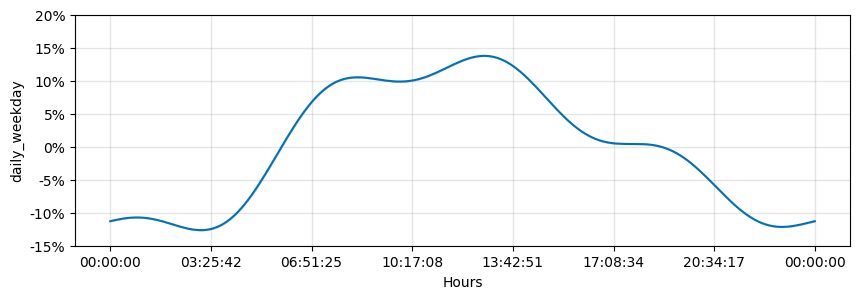

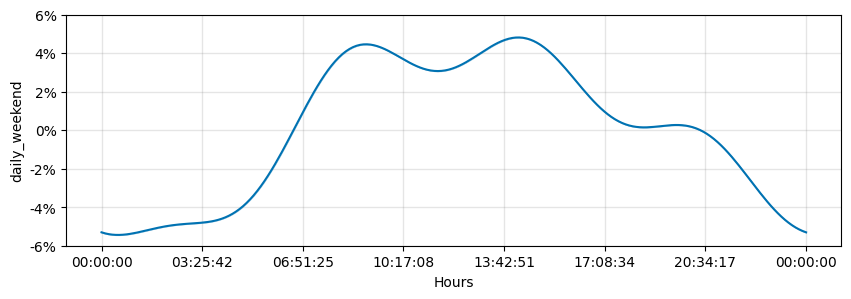

In [168]:


import pandas as pd
import matplotlib.pyplot as plt
import pytz
from prophet import Prophet
from prophet.plot import plot_seasonality
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('May.csv',parse_dates=['time'])

#  Convert to CET and format
cet_timezone = pytz.timezone('CET')
time_series_data_cet = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.strftime('%Y-%m-%d %H:%M:%S')

df = pd.DataFrame({'ds': df['time'],'y': df['people_count']})

#checks if the day of the week for that date is either Friday (4) or Saturday (5). The function returns True if it's a weekend and False otherwise.
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 4 or date.dayofweek == 5)

df['weekend'] = df['ds'].apply(is_weekend)
df['weekday'] = ~df['ds'].apply(is_weekend)

df.head()

#Disable the default daily seasonailty instead use the conditional seasonailty
#Fourier order used to check the goodness of fit. Value too high, fits the curve considering outliers and leads to overfitting
model = Prophet(seasonality_mode='multiplicative',weekly_seasonality=True,daily_seasonality=False)

model.add_seasonality(name='daily_weekend',period=1, fourier_order=4,condition_name='weekend',prior_scale=0.01)

model.add_seasonality(name='daily_weekday', period=1,fourier_order=4,condition_name='weekday',prior_scale=0.01)

model.fit(df)

future = model.make_future_dataframe(periods=2*24,freq='10T')
future['weekend'] =  future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)

forecast = model.predict(future)

fig1 = plot_seasonality(model, 'daily_weekday', figsize=(10, 3))

plt.show()

fig2 = plot_seasonality(model, 'daily_weekend', figsize=(10, 3))

plt.show()

Training Phase Using data June and July

11:42:13 - cmdstanpy - INFO - Chain [1] start processing
11:42:14 - cmdstanpy - INFO - Chain [1] done processing


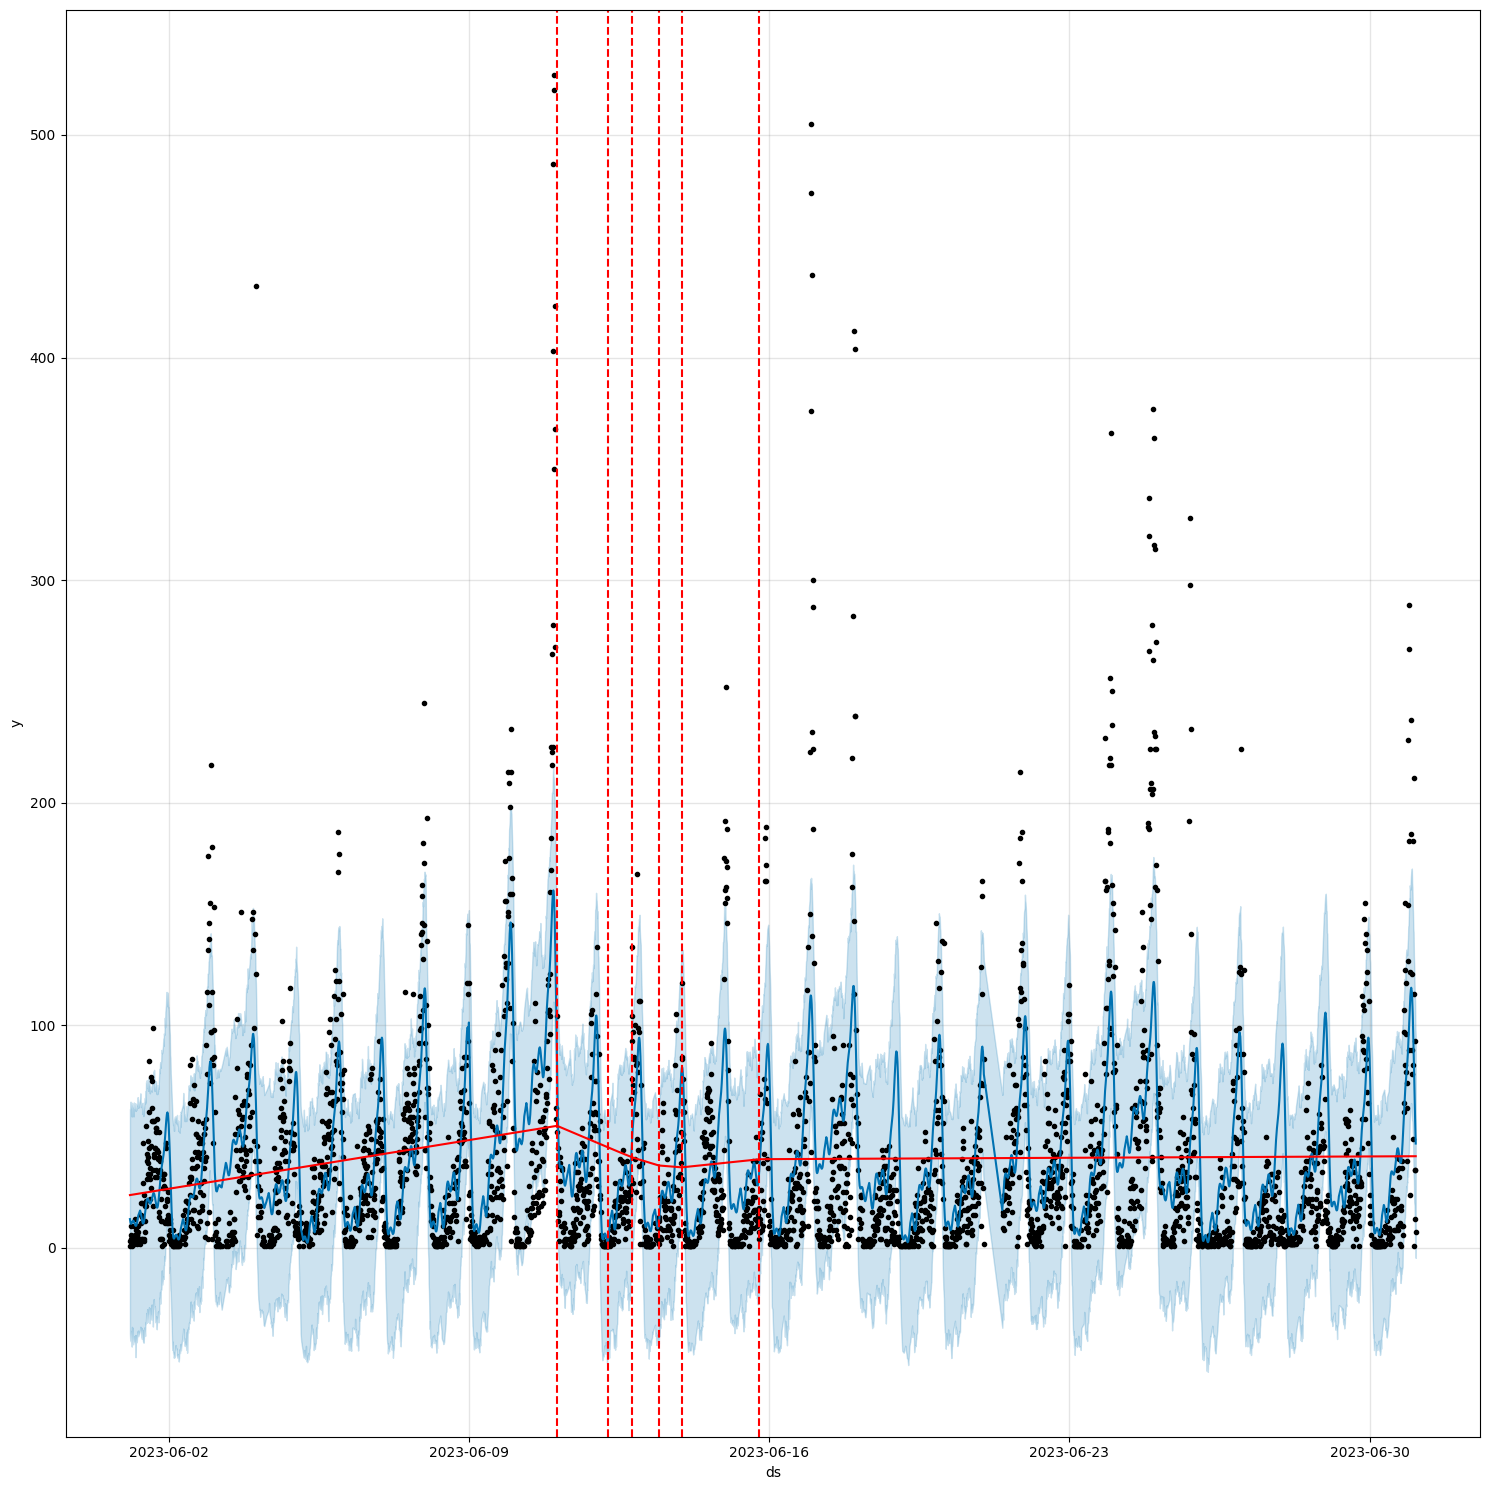

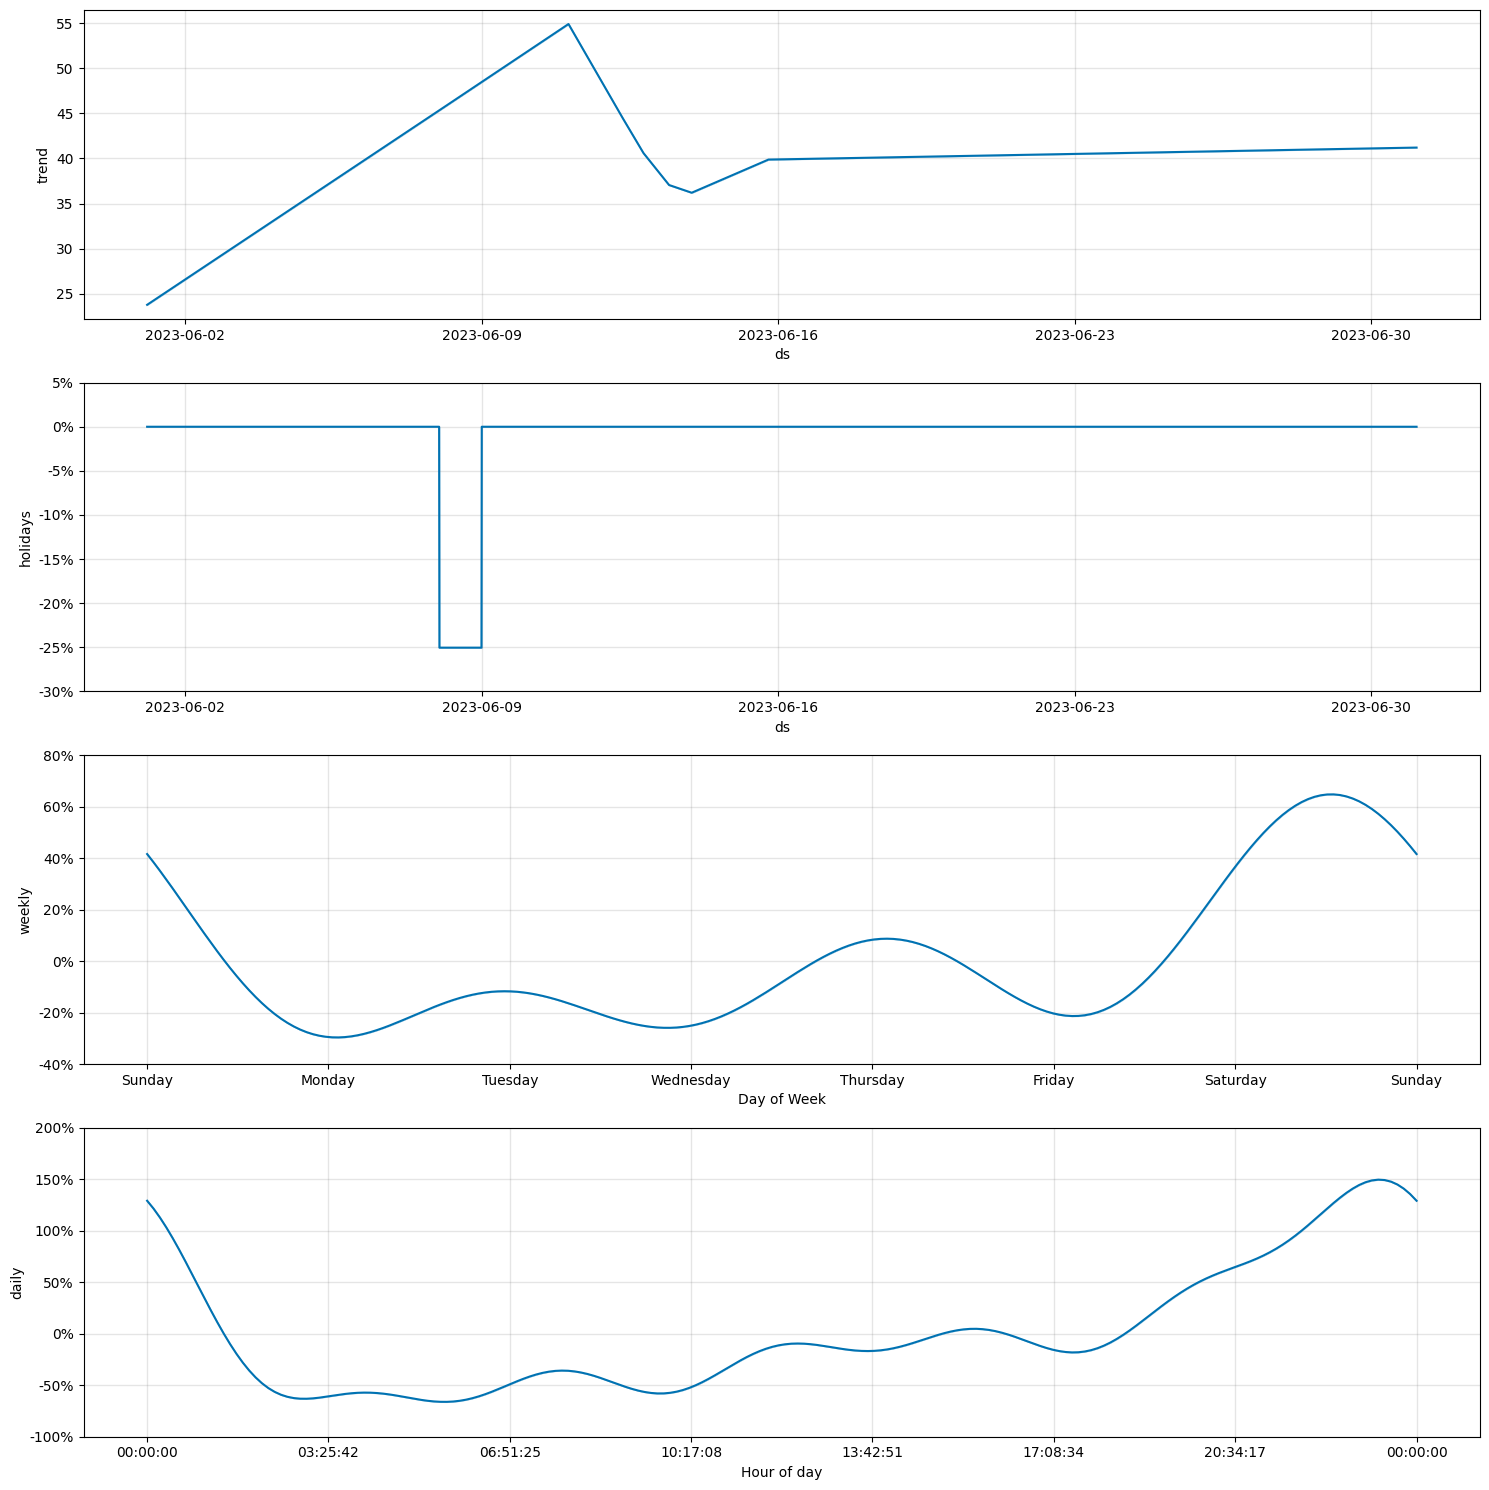

,holiday,effect
0,New Year's Day,0.000000
1,Epiphany,0.000000
2,Good Friday,0.000000
3,Easter Monday,0.000000
4,Labor Day,0.000000
5,Ascension Day,0.000000
6,Whit Monday,0.000000
7,Corpus Christi,-0.250352
8,Assumption Day,0.000000
9,Sandkerwa Fest,0.000000


In [171]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.make_holidays import make_holidays_df

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('June.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)

# Create the training set
training_set = pd.DataFrame({'ds': df['time'], 'y': df['people_count']})
#-------------------------------------------------------------------------------#

# Make sure year_list is a list of integers
year_list = [2023]

# Create a DataFrame of holidays
holidays_df = make_holidays_df(year_list=year_list, country='DE', province='BY')

#-------------------------------------------------------------------------------#
#Adding Sandkerwa 24.8.23 to 28.8.23
sandkerwa_holidays = pd.DataFrame({'holiday':'Sandkerwa Fest',
                                   'ds': pd.to_datetime(['2023-08-24',
                                                         '2023-08-25',
                                                         '2023-08-26',
                                                         '2023-08-27',
                                                         '2023-08-28']),
                                    'lower_window': 0,
                                    'upper_window': 4})

holidays = pd.concat([holidays_df,sandkerwa_holidays]).sort_values('ds').reset_index(drop=True)

#-------------------------------------------------------------------------------#

# Initialize and fit the Prophet model
# The order of a polynomial is proportional to the number of bends the curve can take in order to fit the data.
training_model = Prophet(seasonality_mode='multiplicative',weekly_seasonality=3,daily_seasonality=6,seasonality_prior_scale=0.05,changepoint_prior_scale=0.1,changepoint_range=0.5,holidays=holidays)

training_model.fit(training_set)

# Create a future DataFrame for predictions
# future = training_model.make_future_dataframe(periods=2000, freq='10T')

# Make predictions
forecast = training_model.predict()

fig = training_model.plot(forecast,figsize=(15,15))
# Plot the forecast
# fig_1 = training_model.plot(forecast,figsize=(15,15))
fig_2 = training_model.plot_components(forecast,figsize=(15,15))

#Identifying the trend
add_changepoints_to_plot(fig.gca(), training_model, forecast)
plt.show()
#-------------------------------------------------------------------------------#
#Adding Holidays to the model to see its effect

def first_non_zero(forecast, holiday):
    non_zero_values = forecast[forecast[holiday] != 0][holiday].values
    return non_zero_values[0] if non_zero_values.size > 0 else 0

pd.DataFrame({'holiday': training_model.train_holiday_names,
              'effect': [first_non_zero(forecast, holiday) for holiday in training_model.train_holiday_names]})

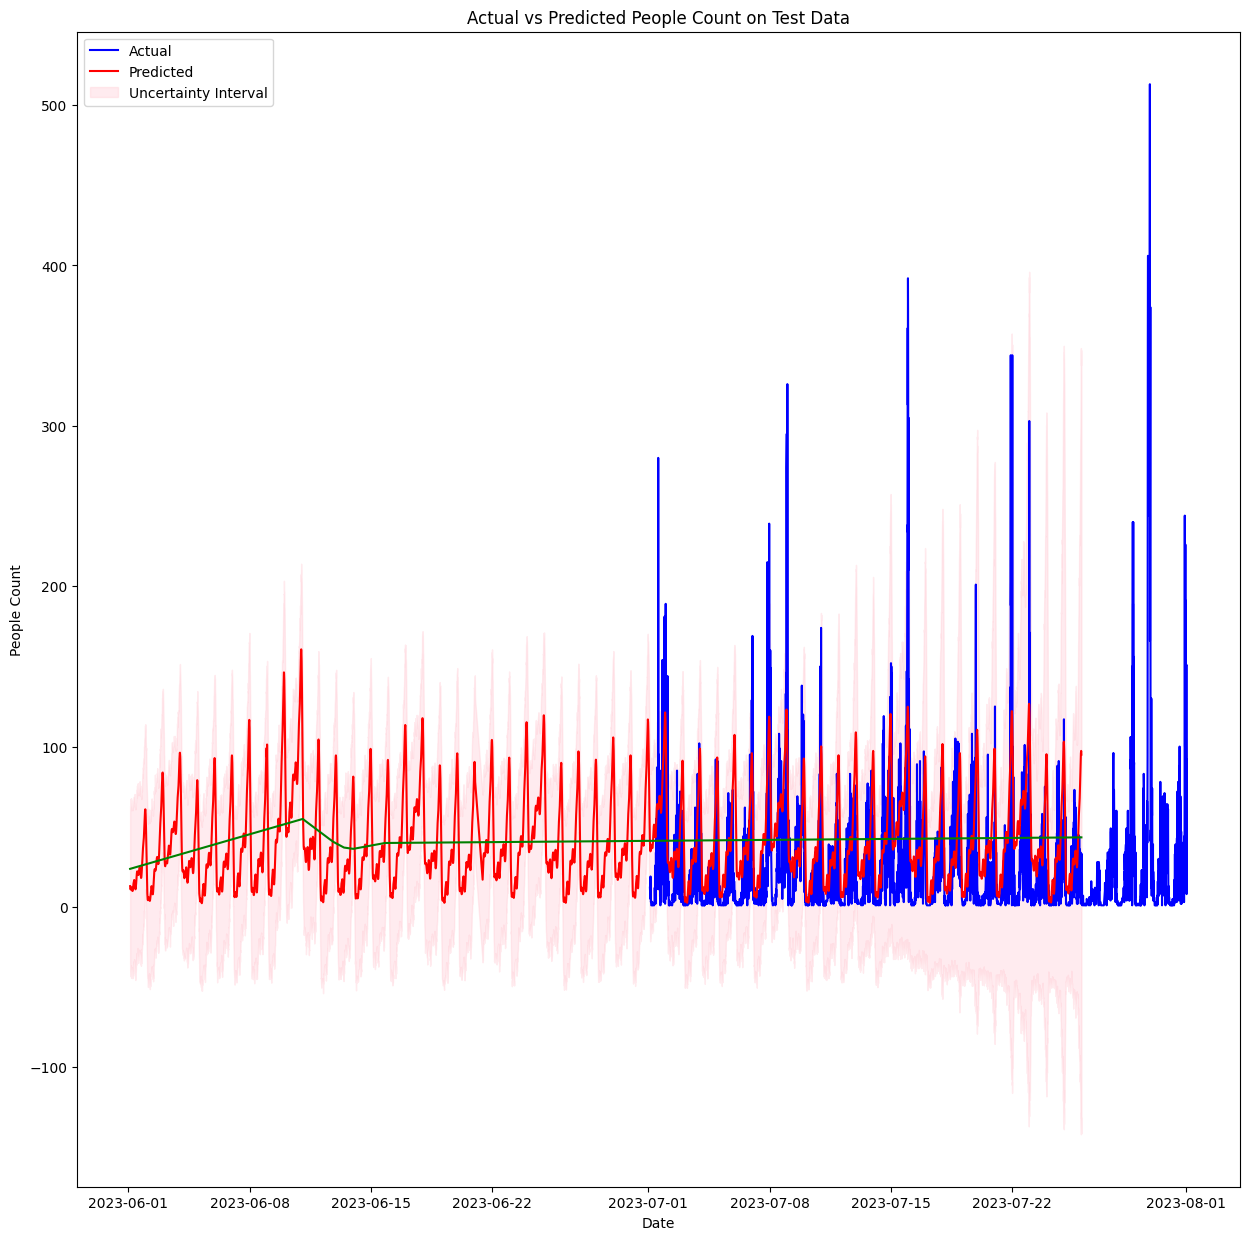

Empty DataFrame
Columns: [ds, Sandkerwa Fest]
Index: []


In [177]:
#Testing the model

# containing datetime values for the test period
df_test = pd.read_csv('July.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df_test['time'] = df_test['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)


# Create the training set
testing_set = pd.DataFrame({'ds': df_test['time'], 'y': df_test['people_count']})


# Create a future DataFrame for the test data
future_test = training_model.make_future_dataframe(periods=len(training_set['ds']), freq='10T')

# Make predictions on the test data
forecast_test = training_model.predict(future_test)




# Plot the actual vs predicted values for the test period
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(testing_set['ds'], testing_set['y'], label='Actual', color='blue')
ax.plot(forecast_test['ds'], forecast_test['yhat'], label='Predicted', color='red')
ax.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='pink', alpha=0.3, label='Uncertainty Interval')
ax.legend()
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count on Test Data')
add_changepoints_to_plot(fig.gca(), training_model, forecast_test,cp_linestyle='',cp_color='green')
plt.show()
print(forecast_test[forecast_test['ds'].isin(['2023-08-24',
                                    '2023-08-25',
                                    '2023-08-26',
                                    '2023-08-27',
                                    '2023-08-28'
                                  ])][['ds','Sandkerwa Fest']])


Weekly Model

Training Phase

12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing


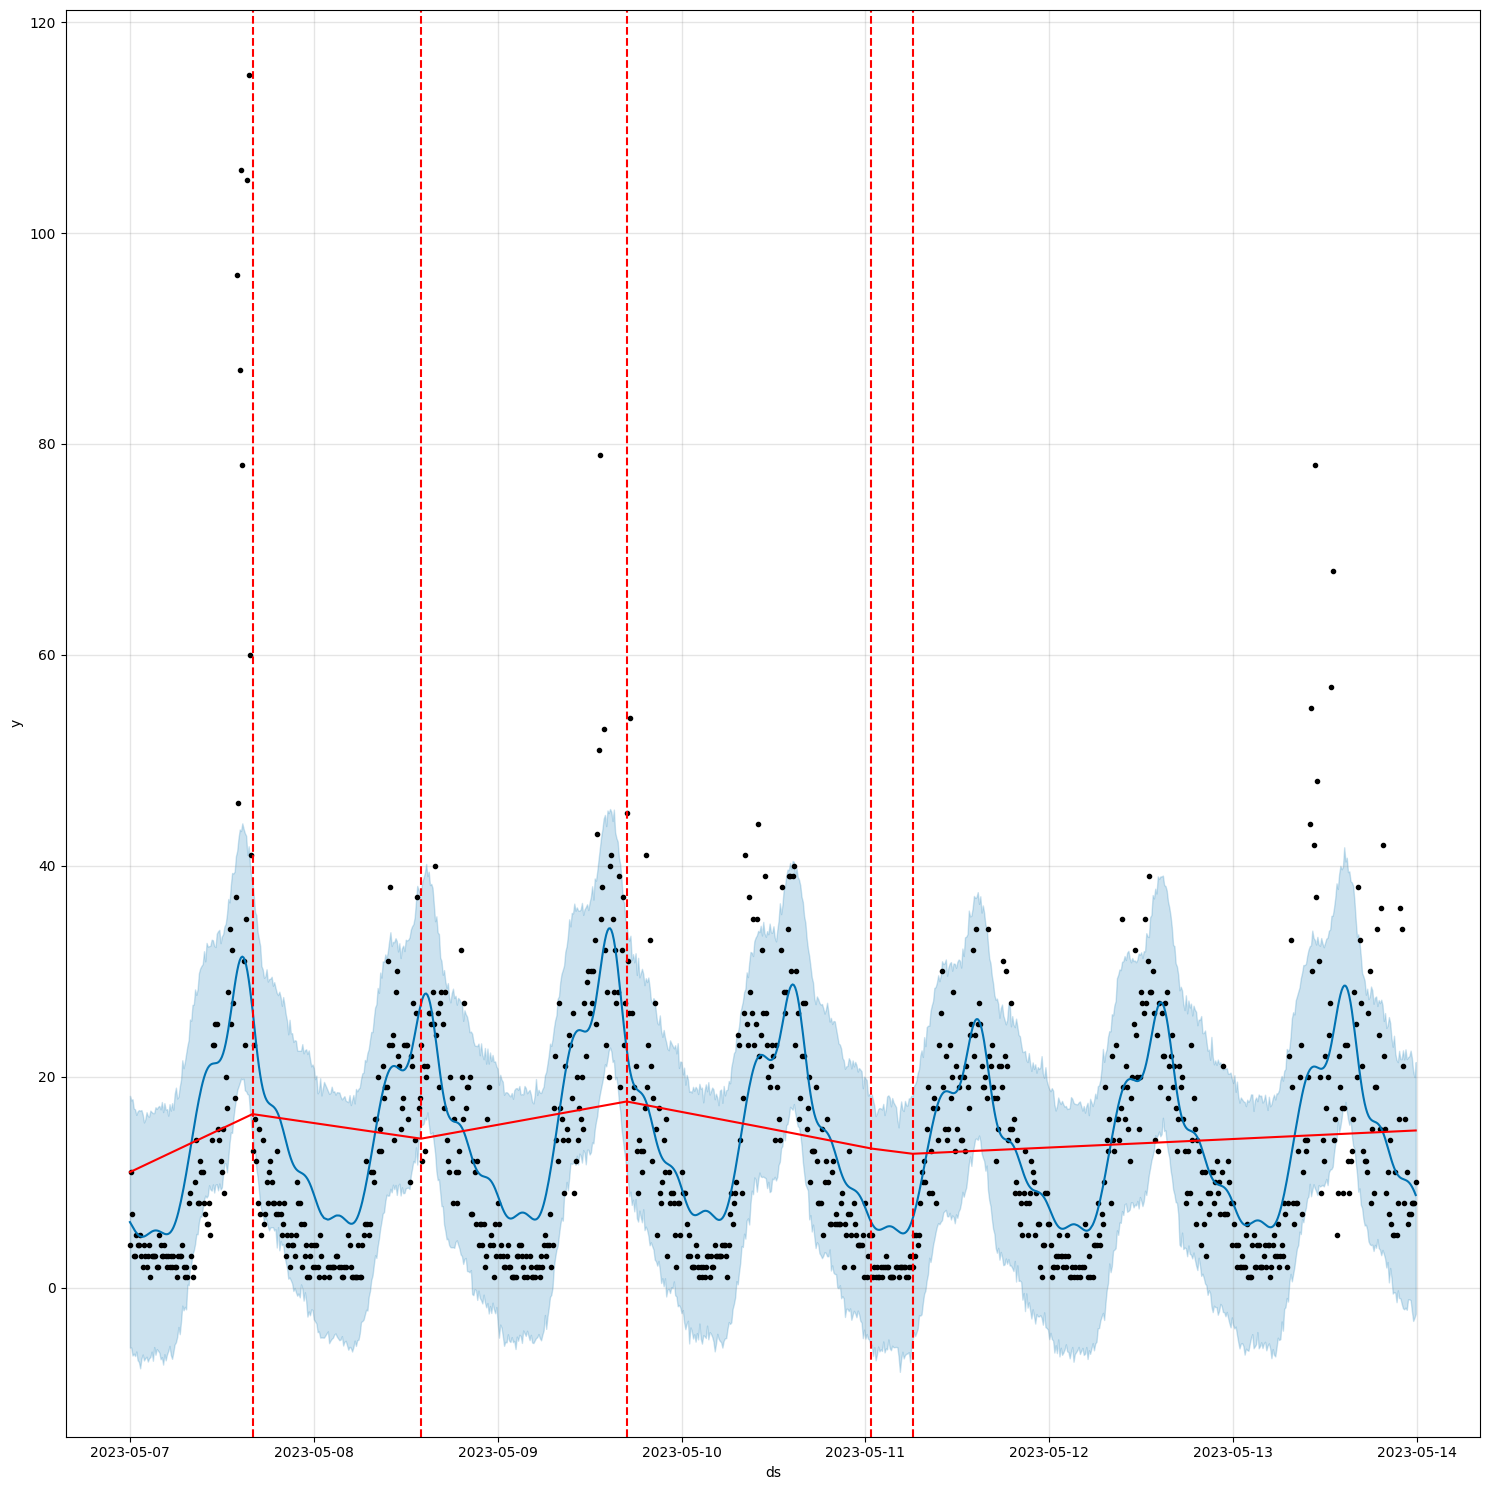

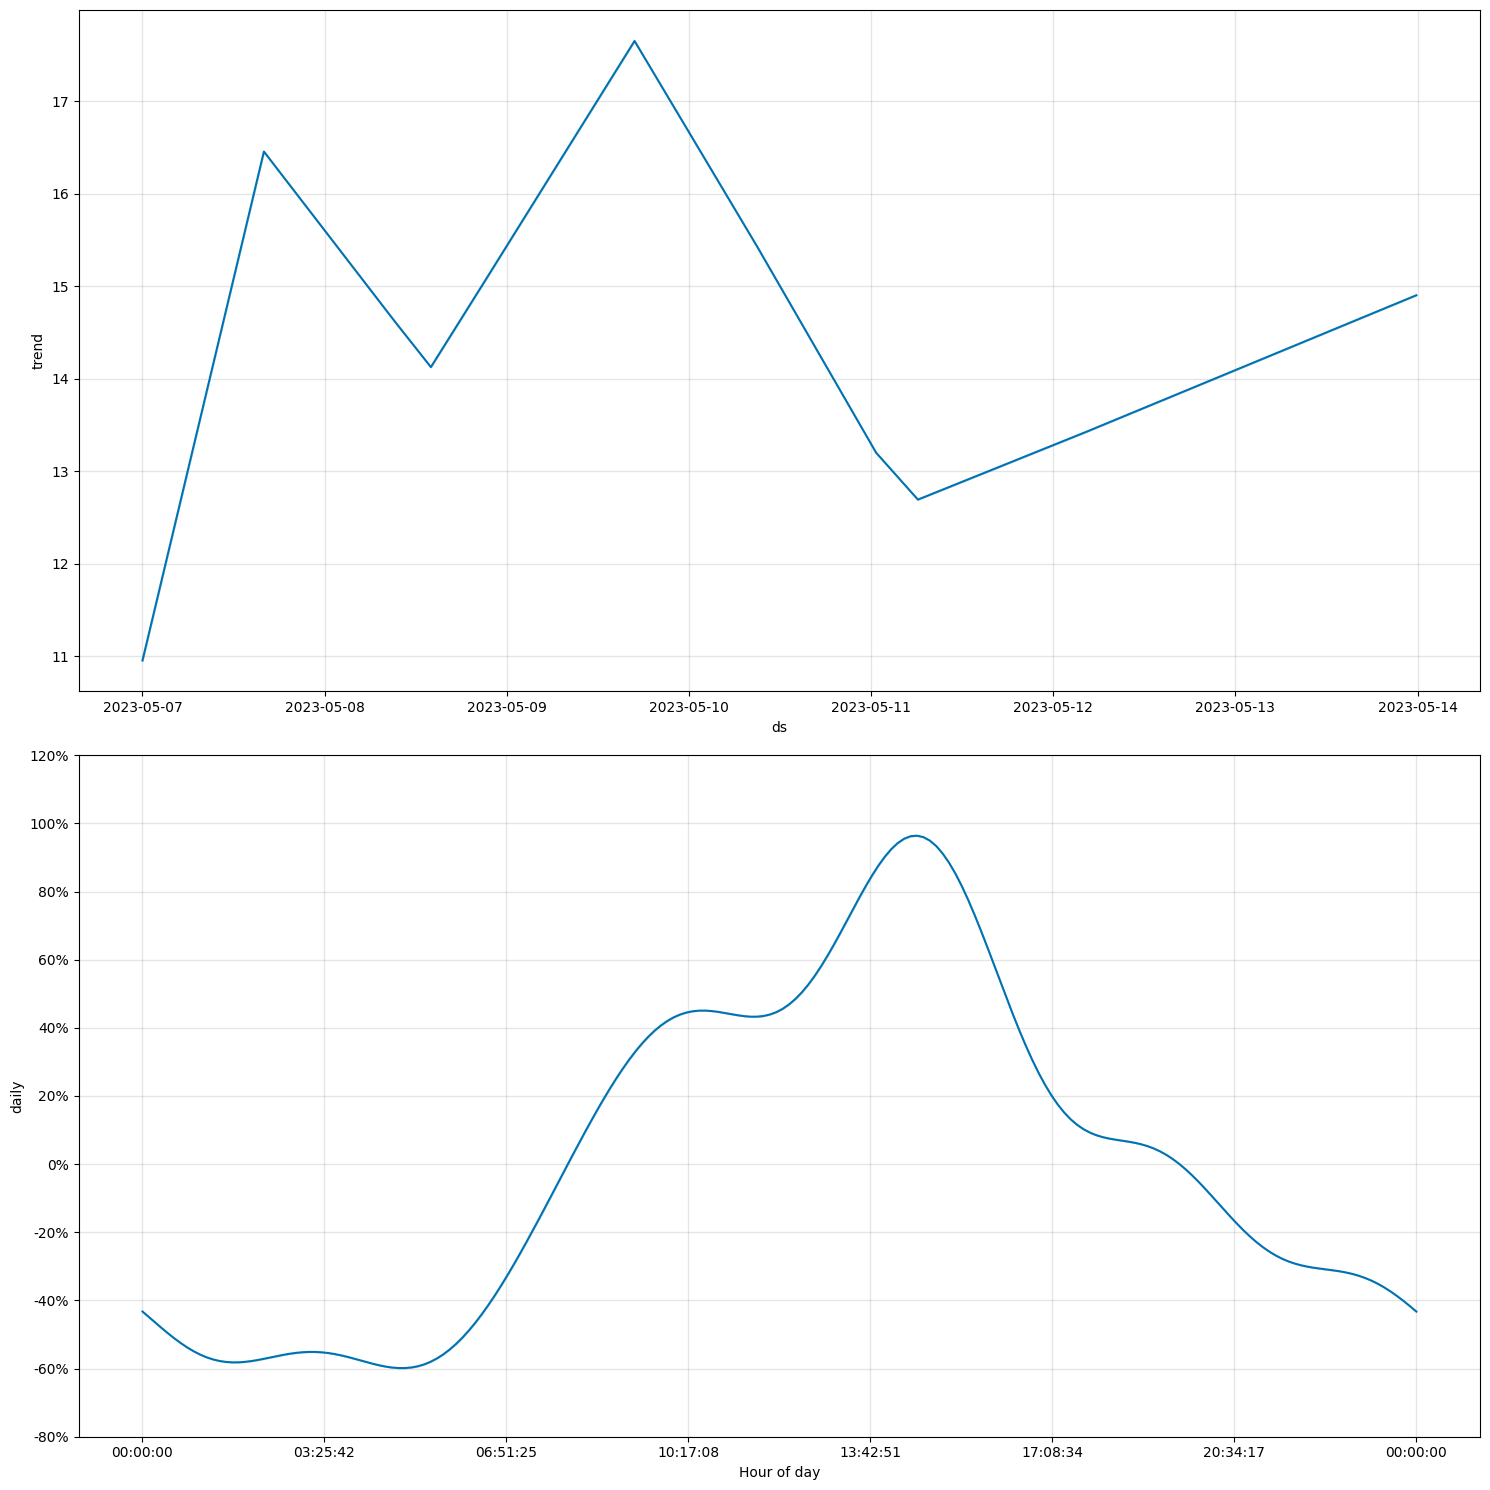

In [191]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)

# Choose the start date and end date for the one-week subset
start_date = '2023-05-07 00:00:00'
end_date = '2023-05-13 23:59:59'

# Filter the DataFrame to include only the data for the selected week
selected_week_data = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

# # Display the selected week data
# print(selected_week_data)

# Create the training set
training_set = pd.DataFrame({'ds': selected_week_data['time'], 'y': selected_week_data['people_count']})


# Initialize and fit the Prophet model for 1 week

weekly_training_model = Prophet(seasonality_mode='multiplicative',daily_seasonality=6,seasonality_prior_scale=0.05,changepoint_prior_scale=0.1)

weekly_training_model.fit(training_set)

# Create a future DataFrame for predictions
# future = weekly_training_model.make_future_dataframe(periods=2000, freq='10T')

# Make predictions
weekly_forecast = weekly_training_model.predict()

fig = weekly_training_model.plot(weekly_forecast,figsize=(15,15))
# Plot the forecast
# fig_1 = training_model.plot(forecast,figsize=(15,15))
fig_2 = weekly_training_model.plot_components(weekly_forecast,figsize=(15,15))

#Identifying the trend
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast)
plt.show()


Testing Phase